# TP - Théorie des Tests Statistiques


Nous allons explorer :
1. Tests de comparaison de moyennes

In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 1. Tests de comparaison de moyennes

Les tests de comparaison de moyennes permettent de déterminer s'il existe une différence significative entre les moyennes de deux populations.

### 1.1 Théorie

Nous avons deux approches principales pour comparer les moyennes de deux populations :

#### Cas 1 : Lorsque les variances σ²ₓ et σ²ᵧ sont connues

La fonction pivotale (statistique de test) est :

$U_0 = \frac{\bar{X}_{n_X} - \bar{Y}_{n_Y}}{\sqrt{\frac{\sigma^2_X}{n_X} + \frac{\sigma^2_Y}{n_Y}}} \sim \mathcal{N}(0, 1)$

Les différentes hypothèses et régions critiques sont :

| ($H_0$) | ($H_1$) | Région Critique |
|------|------|----------------|
| μₓ = μᵧ | μₓ ≠ μᵧ | $RC_{\alpha} = \{\|U_0\| > z_{\frac{\alpha}{2}}\}$ |
| μₓ = μᵧ ou μₓ ≥ μᵧ | μₓ < μᵧ | $RC_{\alpha} = \{U_0 < -z_{\alpha}\}$ |
| μₓ = μᵧ ou μₓ ≤ μᵧ | μₓ > μᵧ | $RC_{\alpha} = \{U_0 > z_{\alpha}\}$ |

où z_β est le quantile d'ordre 1-β de la loi normale centrée réduite.

#### Cas 2 : Lorsque les variances σ²ₓ et σ²ᵧ sont inconnues

La fonction pivotale (statistique de test) devient :

$T_0 = \frac{\bar{X}_{n_X} - \bar{Y}_{n_Y}}{\nu \sqrt{\frac{1}{n_X} + \frac{1}{n_Y}}} \sim T_m$

Avec $\nu^2 = \frac{(n_X-1)S^2_X + (n_Y-1)S^2_Y}{n_X+n_Y-2}$ et m = nₓ + nᵧ - 2 degrés de liberté.

Les différentes hypothèses et régions critiques sont :

| ($H_0$) | ($H_1$) | Région Critique |
|------|------|----------------|
| μₓ = μᵧ | μₓ ≠ μᵧ | $RC_{\alpha} = \{\|T_0\| > t_{m,\frac{\alpha}{2}}\}$ |
| μₓ = μᵧ ou μₓ ≥ μᵧ | μₓ < μᵧ | $RC_{\alpha} = \{T_0 < -t_{m,\alpha}\}$ |
| μₓ = μᵧ ou μₓ ≤ μᵧ | μₓ > μᵧ | $RC_{\alpha} = \{T_0 > t_{m,\alpha}\}$ |

où $t_{m,\beta}$ est le quantile d'ordre 1-$\beta$ de la loi de Student à m degrés de liberté.

### 1.2 Implémentation des tests de comparaison de moyennes

Nous allons maintenant implémenter ces tests en Python et les appliquer sur des exemples.

In [33]:
from enum import Enum
import scipy.stats as stats

class H0ComparaisonMoyennes(Enum):

    EQUALITY = "{mu_x = mu_y}"
    GEQ = "{mu_x >= mu_y}"
    LEQ = "{mu_x <= mu_y}"

class H1ComparaisonMoyennes(Enum):

    EQUALITY = "{mu_x != mu_y}"
    GEQ = "{mu_x < mu_y}"
    LEQ = "{mu_x > mu_y}"

mapping_hypotheses_alternatives = {
    H0ComparaisonMoyennes.EQUALITY: H1ComparaisonMoyennes.EQUALITY,
    H0ComparaisonMoyennes.GEQ: H1ComparaisonMoyennes.GEQ,
    H0ComparaisonMoyennes.LEQ: H1ComparaisonMoyennes.LEQ 
}

def statistique_comparaison_moyennes_sigmas_connus(X, Y, sigma2_X, sigma2_Y):
    return (np.mean(X) - np.mean(Y)) / np.sqrt(sigma2_X/len(X) + sigma2_Y/len(Y))

def statistique_comparaison_moyennes_sigmas_inconnus(X, Y):
    nu_2 = (((len(X)-1)*np.var(X)) + ((len(Y)-1)*np.var(Y)))/(len(X) + len(Y) - 2)
    return (np.mean(X)-np.mean(Y))/np.sqrt(nu_2/len(X) + nu_2/len(Y))

def indicatrice_region_critique_variances_connues(statistique, alpha=0.05, H0=H0ComparaisonMoyennes.EQUALITY):
    if H0 == H0ComparaisonMoyennes.EQUALITY:
        return abs(statistique) > stats.norm.ppf(1 - alpha/2)
    elif H0 == H0ComparaisonMoyennes.GEQ:
        return statistique < -stats.norm.ppf(1 - alpha)
    elif H0 == H0ComparaisonMoyennes.LEQ:
        return statistique > stats.norm.ppf(1 - alpha)
    else:
        raise ValueError(f"Cas d'hypothese non traite: {H0}")
    
def indicatrice_region_critique_variances_inconnues(statistique, m, alpha=0.05, H0=H0ComparaisonMoyennes.EQUALITY):
    if H0 == H0ComparaisonMoyennes.EQUALITY:
        return abs(statistique) > stats.t.ppf(1 - alpha/2, m)
    elif H0 == H0ComparaisonMoyennes.GEQ:
        return statistique < -stats.t.ppf(1 - alpha, m)
    elif H0 == H0ComparaisonMoyennes.LEQ:
        return statistique > stats.t.ppf(1 - alpha, m)
    else:
        raise ValueError(f"Cas d'hypothese non traite: {H0}")


def test_moyennes_variances_connues_live(X, Y, sigma2_X, sigma2_Y, alpha=0.05, H0=H0ComparaisonMoyennes.EQUALITY, verbose=False):
    U = statistique_comparaison_moyennes_sigmas_connus(X, Y, sigma2_X, sigma2_Y)
    indicatrice = indicatrice_region_critique_variances_connues(U, alpha, H0)

    if verbose:
        if indicatrice:
            print(
                f"on rejete H_0={H0.value} et on admet H_1={(mapping_hypotheses_alternatives[H0]).value} au seuil alpha={alpha}.\n"
            )
        else:
            print(
                f"on ne rejete pas H_0={H0.value} au seuil alpha={alpha}.\n"
            )
    return indicatrice

def test_moyennes_variances_inconnues_live(X, Y, alpha=0.05, H0=H0ComparaisonMoyennes.EQUALITY, verbose=False):
    T = statistique_comparaison_moyennes_sigmas_inconnus(X, Y)
    m = len(X) + len(Y) - 2
    indicatrice = indicatrice_region_critique_variances_inconnues(T, m, alpha, H0)

    if verbose:
        if indicatrice:
            print(
                f"on rejete H_0={H0.value} et on admet H_1={(mapping_hypotheses_alternatives[H0]).value} au seuil alpha={alpha}.\n"
            )
        else:
            print(
                f"on ne rejete pas H_0={H0.value} au seuil alpha={alpha}.\n"
            )
    return indicatrice

In [35]:
import numpy as np

# Générateur de nombres aléatoires pour la reproductibilité
np.random.seed(0)

# Exemple 1: Deux populations avec des moyennes différentes et variances connues
mu_X = 10
mu_Y = 12
sigma_X = 3
sigma_Y = 2.5
n_X = 300
n_Y = 250

# Génération des échantillons
X = np.random.normal(mu_X, sigma_X, n_X)
Y = np.random.normal(mu_Y, sigma_Y, n_Y)

# Test d'hypothèse avec variances connues
print("Test d'hypothèse avec variances connues:")
_ = test_moyennes_variances_connues_live(X, Y, sigma_X**2, sigma_Y**2, alpha=0.05, verbose=True)
print("\n\n")
print("Test d'hypothèse avec variances inconnues:")
_ = test_moyennes_variances_inconnues_live(X, Y, alpha=0.05, verbose=True)

Test d'hypothèse avec variances connues:
on rejete H_0={mu_x = mu_y} et on admet H_1={mu_x != mu_y} au seuil alpha=0.05.




Test d'hypothèse avec variances inconnues:
on rejete H_0={mu_x = mu_y} et on admet H_1={mu_x != mu_y} au seuil alpha=0.05.



In [41]:
import matplotlib.pyplot as plt

rejet_connus = []
rejet_inconnus = []
np.random.seed(0)
for taille in range(10, 400, 5):
    X = np.random.normal(mu_X, sigma_X, taille)
    Y = np.random.normal(mu_Y, sigma_Y, taille)
    rejet_connus.append(test_moyennes_variances_connues_live(X, Y, sigma_X**2, sigma_Y**2))
    rejet_inconnus.append(test_moyennes_variances_inconnues_live(X, Y))

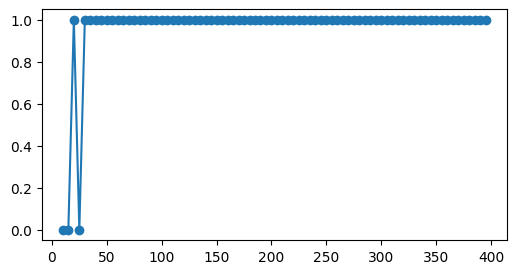

In [42]:
# Visualisation des résultats
plt.figure(figsize=(6, 3))
plt.plot(range(10, 400, 5), np.array(rejet_connus)*1, label='Variances Connues', marker='o')
plt.show()

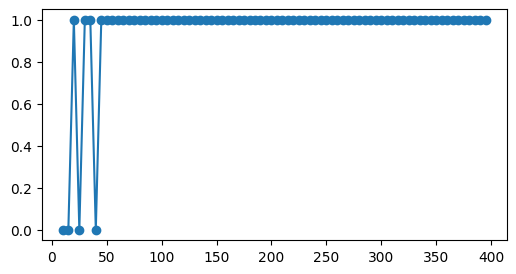

In [43]:
plt.figure(figsize=(6, 3))
plt.plot(range(10, 400, 5), np.array(rejet_inconnus)*1, label='Variances Inconnues', marker='o')
plt.show()

In [2]:
def test_moyennes_variances_connues(X, Y, sigma2_X, sigma2_Y, alpha=0.05, alternative='two-sided'):
    """
    Test de comparaison de moyennes lorsque les variances sont connues
    
    Paramètres :
    X : tableau numpy, échantillon de la population X
    Y : tableau numpy, échantillon de la population Y
    sigma2_X : float, variance connue de la population X
    sigma2_Y : float, variance connue de la population Y
    alpha : float, niveau de signification (défaut: 0.05)
    alternative : string, type d'hypothèse alternative ('two-sided', 'less', 'greater')
    
    Retourne :
    U0 : float, valeur de la statistique de test
    p_value : float, p-valeur du test
    critical_value : float, valeur critique
    reject_H0 : bool, décision de rejeter H0 ou non
    """
    # Calcul des tailles d'échantillon
    n_X = len(X)
    n_Y = len(Y)
    
    # Calcul des moyennes d'échantillon
    X_bar = np.mean(X)
    Y_bar = np.mean(Y)
    
    # Calcul de la statistique de test U0
    denominateur = np.sqrt(sigma2_X/n_X + sigma2_Y/n_Y)
    U0 = (X_bar - Y_bar) / denominateur
    
    # Calcul de la valeur critique et de la p-valeur en fonction du type d'alternative
    if alternative == 'two-sided':
        critical_value = stats.norm.ppf(1 - alpha/2)
        p_value = 2 * (1 - stats.norm.cdf(abs(U0)))
        reject_H0 = abs(U0) > critical_value
    elif alternative == 'less':
        critical_value = stats.norm.ppf(alpha)
        p_value = stats.norm.cdf(U0)
        reject_H0 = U0 < critical_value
    elif alternative == 'greater':
        critical_value = stats.norm.ppf(1 - alpha)
        p_value = 1 - stats.norm.cdf(U0)
        reject_H0 = U0 > critical_value
    else:
        raise ValueError("'alternative' doit être 'two-sided', 'less' ou 'greater'")
    
    return U0, p_value, critical_value, reject_H0

In [3]:
def test_moyennes_variances_inconnues(X, Y, alpha=0.05, alternative='two-sided', equal_var=True):
    """
    Test de comparaison de moyennes lorsque les variances sont inconnues
    
    Paramètres :
    X : tableau numpy, échantillon de la population X
    Y : tableau numpy, échantillon de la population Y
    alpha : float, niveau de signification (défaut: 0.05)
    alternative : string, type d'hypothèse alternative ('two-sided', 'less', 'greater')
    equal_var : bool, si True, suppose que les variances sont égales (défaut: True)
    
    Retourne :
    T0 : float, valeur de la statistique de test
    p_value : float, p-valeur du test
    critical_value : float, valeur critique
    reject_H0 : bool, décision de rejeter H0 ou non
    nu : float, estimation de l'écart-type poolé
    """
    # Calcul des tailles d'échantillon
    n_X = len(X)
    n_Y = len(Y)
    
    # Calcul des moyennes d'échantillon
    X_bar = np.mean(X)
    Y_bar = np.mean(Y)
    
    # Calcul des variances d'échantillon
    S2_X = np.var(X, ddof=1)  # ddof=1 pour utiliser la formule corrigée (n-1)
    S2_Y = np.var(Y, ddof=1)
    
    # Calcul des degrés de liberté
    df = n_X + n_Y - 2
    
    if equal_var:
        # Calcul de nu^2 (variance poolée) sous l'hypothèse de variances égales
        nu2 = ((n_X - 1) * S2_X + (n_Y - 1) * S2_Y) / df
        nu = np.sqrt(nu2)
        
        # Calcul de T0
        T0 = (X_bar - Y_bar) / (nu * np.sqrt(1/n_X + 1/n_Y))
    else:
        # Test de Welch pour variances inégales
        var_X = S2_X / n_X
        var_Y = S2_Y / n_Y
        T0 = (X_bar - Y_bar) / np.sqrt(var_X + var_Y)
        
        # Calcul des degrés de liberté de Welch
        df = ((var_X + var_Y)**2) / ((var_X**2 / (n_X - 1)) + (var_Y**2 / (n_Y - 1)))
        nu = None  # Non applicable dans ce cas
    
    # Calcul de la valeur critique et de la p-valeur en fonction du type d'alternative
    if alternative == 'two-sided':
        critical_value = stats.t.ppf(1 - alpha/2, df)
        p_value = 2 * (1 - stats.t.cdf(abs(T0), df))
        reject_H0 = abs(T0) > critical_value
    elif alternative == 'less':
        critical_value = stats.t.ppf(alpha, df)
        p_value = stats.t.cdf(T0, df)
        reject_H0 = T0 < critical_value
    elif alternative == 'greater':
        critical_value = stats.t.ppf(1 - alpha, df)
        p_value = 1 - stats.t.cdf(T0, df)
        reject_H0 = T0 > critical_value
    else:
        raise ValueError("'alternative' doit être 'two-sided', 'less' ou 'greater'")
    
    return T0, p_value, critical_value, reject_H0, nu

### 1.3 Exemples d'application des tests de comparaison de moyennes

Maintenant, appliquons ces tests sur des données simulées.

Échantillon X:
  Moyenne: 11.3286
  Écart-type: 3.3010
  Taille: 30

Échantillon Y:
  Moyenne: 11.1514
  Écart-type: 2.4506
  Taille: 25


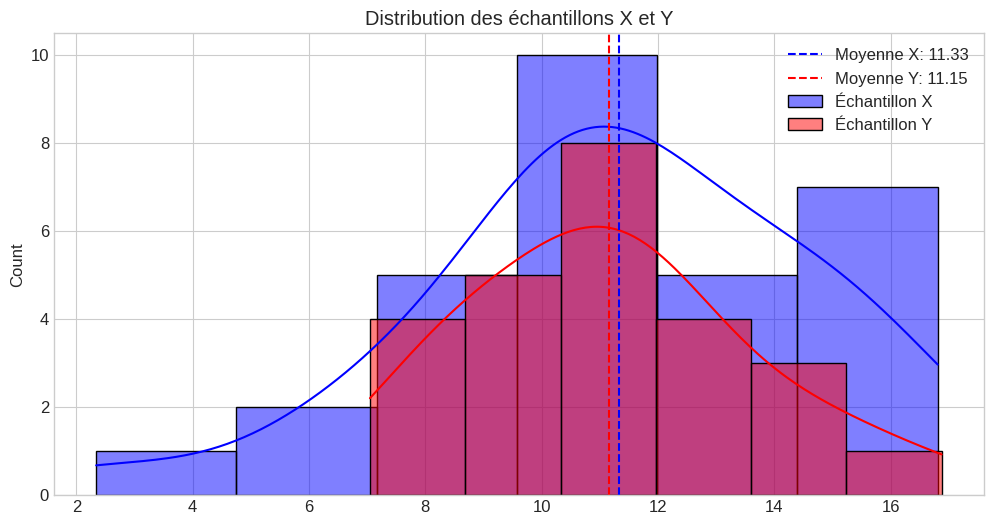

In [4]:
# Générateur de nombres aléatoires pour la reproductibilité
np.random.seed(0)

# Exemple 1: Deux populations avec des moyennes différentes et variances connues
mu_X = 10
mu_Y = 12
sigma_X = 3
sigma_Y = 2.5
n_X = 30
n_Y = 25

# Génération des échantillons
X = np.random.normal(mu_X, sigma_X, n_X)
Y = np.random.normal(mu_Y, sigma_Y, n_Y)

# Affichage des statistiques descriptives
print("Échantillon X:")
print(f"  Moyenne: {np.mean(X):.4f}")
print(f"  Écart-type: {np.std(X, ddof=1):.4f}")
print(f"  Taille: {len(X)}")
print("\nÉchantillon Y:")
print(f"  Moyenne: {np.mean(Y):.4f}")
print(f"  Écart-type: {np.std(Y, ddof=1):.4f}")
print(f"  Taille: {len(Y)}")

# Visualisation des distributions
plt.figure(figsize=(12, 6))
sns.histplot(X, kde=True, color='blue', alpha=0.5, label='Échantillon X')
sns.histplot(Y, kde=True, color='red', alpha=0.5, label='Échantillon Y')
plt.axvline(np.mean(X), color='blue', linestyle='--', label=f'Moyenne X: {np.mean(X):.2f}')
plt.axvline(np.mean(Y), color='red', linestyle='--', label=f'Moyenne Y: {np.mean(Y):.2f}')
plt.title('Distribution des échantillons X et Y')
plt.legend()
plt.grid(True)
plt.show()

Test de comparaison des moyennes avec variances connues (test bilatéral)
H0: μₓ = μᵧ contre H1: μₓ ≠ μᵧ
Statistique U0: 0.2389
Valeur critique à α=0.05: ±1.9600
p-valeur: 0.8112
Décision: Ne pas rejeter H0
Conclusion: Il n'y a pas de différence significative entre les moyennes


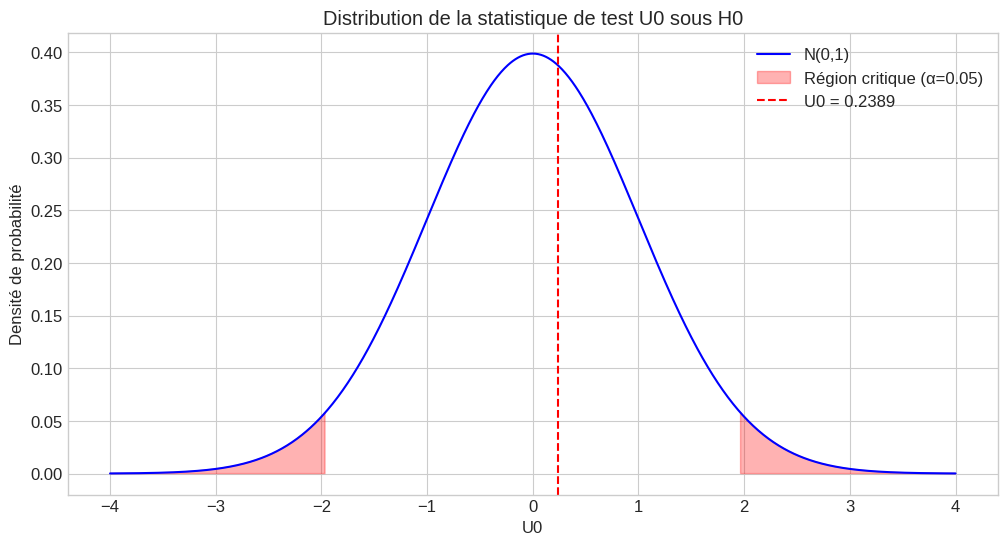

In [5]:
# Test de comparaison des moyennes avec variances connues
# Utilisons les vraies variances des populations
sigma2_X = sigma_X**2
sigma2_Y = sigma_Y**2

# Test bilatéral: H0: μₓ = μᵧ contre H1: μₓ ≠ μᵧ
U0, p_value, critical_value, reject_H0 = test_moyennes_variances_connues(
    X, Y, sigma2_X, sigma2_Y, alpha=0.05, alternative='two-sided')

print("Test de comparaison des moyennes avec variances connues (test bilatéral)")
print(f"H0: μₓ = μᵧ contre H1: μₓ ≠ μᵧ")
print(f"Statistique U0: {U0:.4f}")
print(f"Valeur critique à α=0.05: ±{critical_value:.4f}")
print(f"p-valeur: {p_value:.4f}")
print(f"Décision: {'Rejeter H0' if reject_H0 else 'Ne pas rejeter H0'}")
print(f"Conclusion: {'Il existe une différence significative entre les moyennes' if reject_H0 else 'Il n\'y a pas de différence significative entre les moyennes'}")

# Visualisation de la distribution de la statistique de test sous H0
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(12, 6))
plt.plot(x, y, 'b-', label='N(0,1)')
plt.fill_between(x, y, where=(x >= critical_value) | (x <= -critical_value), color='red', alpha=0.3, label=f'Région critique (α=0.05)')
plt.axvline(U0, color='red', linestyle='--', label=f'U0 = {U0:.4f}')
plt.title('Distribution de la statistique de test U0 sous H0')
plt.xlabel('U0')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Test unilatéral à gauche: H0: μₓ = μᵧ ou μₓ ≥ μᵧ contre H1: μₓ < μᵧ
U0, p_value, critical_value, reject_H0 = test_moyennes_variances_connues(
    X, Y, sigma2_X, sigma2_Y, alpha=0.05, alternative='less')

print("Test de comparaison des moyennes avec variances connues (test unilatéral à gauche)")
print(f"H0: μₓ = μᵧ ou μₓ ≥ μᵧ contre H1: μₓ < μᵧ")
print(f"Statistique U0: {U0:.4f}")
print(f"Valeur critique à α=0.05: {critical_value:.4f}")
print(f"p-valeur: {p_value:.4f}")
print(f"Décision: {'Rejeter H0' if reject_H0 else 'Ne pas rejeter H0'}")
print(f"Conclusion: {'La moyenne de X est significativement inférieure à celle de Y' if reject_H0 else 'On ne peut pas conclure que la moyenne de X est inférieure à celle de Y'}")

# Test unilatéral à droite: H0: μₓ = μᵧ ou μₓ ≤ μᵧ contre H1: μₓ > μᵧ
U0, p_value, critical_value, reject_H0 = test_moyennes_variances_connues(
    X, Y, sigma2_X, sigma2_Y, alpha=0.05, alternative='greater')

print("\nTest de comparaison des moyennes avec variances connues (test unilatéral à droite)")
print(f"H0: μₓ = μᵧ ou μₓ ≤ μᵧ contre H1: μₓ > μᵧ")
print(f"Statistique U0: {U0:.4f}")
print(f"Valeur critique à α=0.05: {critical_value:.4f}")
print(f"p-valeur: {p_value:.4f}")
print(f"Décision: {'Rejeter H0' if reject_H0 else 'Ne pas rejeter H0'}")
print(f"Conclusion: {'La moyenne de X est significativement supérieure à celle de Y' if reject_H0 else 'On ne peut pas conclure que la moyenne de X est supérieure à celle de Y'}")

Test de comparaison des moyennes avec variances connues (test unilatéral à gauche)
H0: μₓ = μᵧ ou μₓ ≥ μᵧ contre H1: μₓ < μᵧ
Statistique U0: 0.2389
Valeur critique à α=0.05: -1.6449
p-valeur: 0.5944
Décision: Ne pas rejeter H0
Conclusion: On ne peut pas conclure que la moyenne de X est inférieure à celle de Y

Test de comparaison des moyennes avec variances connues (test unilatéral à droite)
H0: μₓ = μᵧ ou μₓ ≤ μᵧ contre H1: μₓ > μᵧ
Statistique U0: 0.2389
Valeur critique à α=0.05: 1.6449
p-valeur: 0.4056
Décision: Ne pas rejeter H0
Conclusion: On ne peut pas conclure que la moyenne de X est supérieure à celle de Y


### 1.4 Test avec variances inconnues

Maintenant, supposons que nous ne connaissons pas les variances des populations et utilisons notre deuxième fonction.

Test de Student pour la comparaison des moyennes avec variances inconnues (test bilatéral)
H0: μₓ = μᵧ contre H1: μₓ ≠ μᵧ
Statistique T0: 0.2220
Degrés de liberté: 53
Écart-type poolé (ν): 2.9465
Valeur critique à α=0.05: ±2.0057
p-valeur: 0.8251
Décision: Ne pas rejeter H0
Conclusion: Il n'y a pas de différence significative entre les moyennes


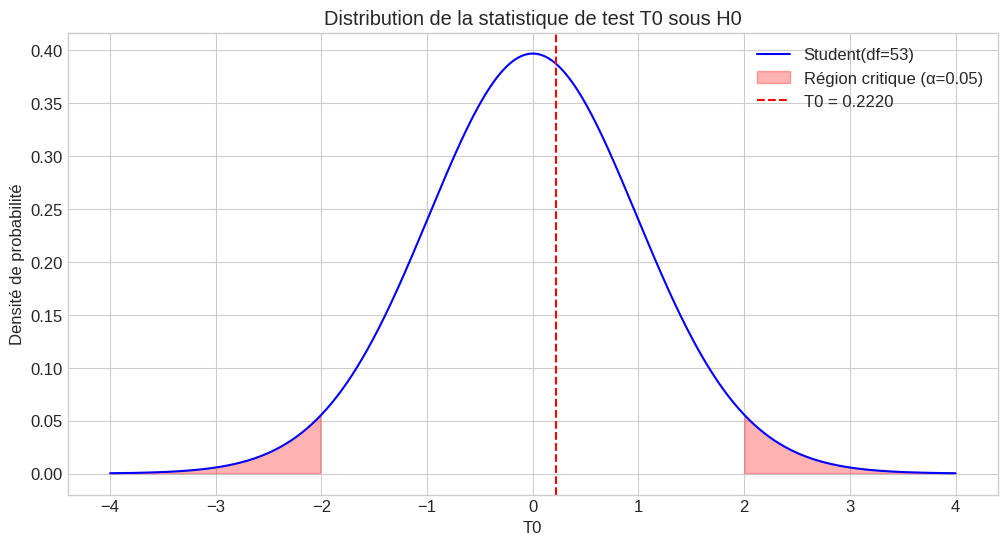

In [7]:
# Exemple 2: Deux populations avec des moyennes différentes et variances inconnues
# On utilise les mêmes données que précédemment mais on prétend ne pas connaître les variances

# Test bilatéral: H0: μₓ = μᵧ contre H1: μₓ ≠ μᵧ
T0, p_value, critical_value, reject_H0, nu = test_moyennes_variances_inconnues(
    X, Y, alpha=0.05, alternative='two-sided', equal_var=True)

# Degrés de liberté
df = len(X) + len(Y) - 2

print("Test de Student pour la comparaison des moyennes avec variances inconnues (test bilatéral)")
print(f"H0: μₓ = μᵧ contre H1: μₓ ≠ μᵧ")
print(f"Statistique T0: {T0:.4f}")
print(f"Degrés de liberté: {df}")
print(f"Écart-type poolé (ν): {nu:.4f}")
print(f"Valeur critique à α=0.05: ±{critical_value:.4f}")
print(f"p-valeur: {p_value:.4f}")
print(f"Décision: {'Rejeter H0' if reject_H0 else 'Ne pas rejeter H0'}")
print(f"Conclusion: {'Il existe une différence significative entre les moyennes' if reject_H0 else 'Il n\'y a pas de différence significative entre les moyennes'}")

# Visualisation de la distribution de la statistique de test sous H0
x = np.linspace(-4, 4, 1000)
y = stats.t.pdf(x, df)

plt.figure(figsize=(12, 6))
plt.plot(x, y, 'b-', label=f'Student(df={df})')
plt.fill_between(x, y, where=(x >= critical_value) | (x <= -critical_value), color='red', alpha=0.3, label=f'Région critique (α=0.05)')
plt.axvline(T0, color='red', linestyle='--', label=f'T0 = {T0:.4f}')
plt.title('Distribution de la statistique de test T0 sous H0')
plt.xlabel('T0')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Test unilatéral à gauche: H0: μₓ = μᵧ ou μₓ ≥ μᵧ contre H1: μₓ < μᵧ
T0, p_value, critical_value, reject_H0, nu = test_moyennes_variances_inconnues(
    X, Y, alpha=0.05, alternative='less', equal_var=True)

print("Test de Student pour la comparaison des moyennes avec variances inconnues (test unilatéral à gauche)")
print(f"H0: μₓ = μᵧ ou μₓ ≥ μᵧ contre H1: μₓ < μᵧ")
print(f"Statistique T0: {T0:.4f}")
print(f"Valeur critique à α=0.05: {critical_value:.4f}")
print(f"p-valeur: {p_value:.4f}")
print(f"Décision: {'Rejeter H0' if reject_H0 else 'Ne pas rejeter H0'}")
print(f"Conclusion: {'La moyenne de X est significativement inférieure à celle de Y' if reject_H0 else 'On ne peut pas conclure que la moyenne de X est inférieure à celle de Y'}")

# Test unilatéral à droite: H0: μₓ = μᵧ ou μₓ ≤ μᵧ contre H1: μₓ > μᵧ
T0, p_value, critical_value, reject_H0, nu = test_moyennes_variances_inconnues(
    X, Y, alpha=0.05, alternative='greater', equal_var=True)

print("\nTest de Student pour la comparaison des moyennes avec variances inconnues (test unilatéral à droite)")
print(f"H0: μₓ = μᵧ ou μₓ ≤ μᵧ contre H1: μₓ > μᵧ")
print(f"Statistique T0: {T0:.4f}")
print(f"Valeur critique à α=0.05: {critical_value:.4f}")
print(f"p-valeur: {p_value:.4f}")
print(f"Décision: {'Rejeter H0' if reject_H0 else 'Ne pas rejeter H0'}")
print(f"Conclusion: {'La moyenne de X est significativement supérieure à celle de Y' if reject_H0 else 'On ne peut pas conclure que la moyenne de X est supérieure à celle de Y'}")

# Test unilatéral à droite: H0: μₓ = μᵧ ou μₓ ≤ μᵧ contre H1: μₓ > μᵧ
T0, p_value, critical_value, reject_H0, nu = test_moyennes_variances_inconnues(
    X, Y, alpha=0.05, alternative='greater', equal_var=False)

print("\nTest de Student pour la comparaison des moyennes avec variances inconnues (test unilatéral à droite)")
print(f"H0: μₓ = μᵧ ou μₓ ≤ μᵧ contre H1: μₓ > μᵧ")
print(f"Statistique T0: {T0:.4f}")
print(f"Valeur critique à α=0.05: {critical_value:.4f}")
print(f"p-valeur: {p_value:.4f}")
print(f"Décision: {'Rejeter H0' if reject_H0 else 'Ne pas rejeter H0'}")
print(f"Conclusion: {'La moyenne de X est significativement supérieure à celle de Y' if reject_H0 else 'On ne peut pas conclure que la moyenne de X est supérieure à celle de Y'}")

Test de Student pour la comparaison des moyennes avec variances inconnues (test unilatéral à gauche)
H0: μₓ = μᵧ ou μₓ ≥ μᵧ contre H1: μₓ < μᵧ
Statistique T0: 0.2220
Valeur critique à α=0.05: -1.6741
p-valeur: 0.5874
Décision: Ne pas rejeter H0
Conclusion: On ne peut pas conclure que la moyenne de X est inférieure à celle de Y

Test de Student pour la comparaison des moyennes avec variances inconnues (test unilatéral à droite)
H0: μₓ = μᵧ ou μₓ ≤ μᵧ contre H1: μₓ > μᵧ
Statistique T0: 0.2220
Valeur critique à α=0.05: 1.6741
p-valeur: 0.4126
Décision: Ne pas rejeter H0
Conclusion: On ne peut pas conclure que la moyenne de X est supérieure à celle de Y

Test de Student pour la comparaison des moyennes avec variances inconnues (test unilatéral à droite)
H0: μₓ = μᵧ ou μₓ ≤ μᵧ contre H1: μₓ > μᵧ
Statistique T0: 0.2281
Valeur critique à α=0.05: 1.6745
p-valeur: 0.4102
Décision: Ne pas rejeter H0
Conclusion: On ne peut pas conclure que la moyenne de X est supérieure à celle de Y
